In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
X_train = np.loadtxt('./movies3/trainRatings.txt', comments='#', delimiter=',', unpack=False)
y_train = np.loadtxt('./movies3/trainLabels.txt', comments='#', delimiter=',', unpack=False)
X_test = np.loadtxt('./movies3/testRatings.txt', comments='#', delimiter=',', unpack=False)
y_test = np.loadtxt('./movies3/testLabels.txt', comments='#', delimiter=',', unpack=False)
group_labels = np.loadtxt('./movies3/groupLabelsPerRating.txt', comments='#', delimiter=',', unpack=False)
group_titles = np.genfromtxt('./movies3/groupTitles.txt', dtype='str')
data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test,
    'group_labels': group_labels,
    'group_titles': group_titles
}

In [31]:
for key, value in data.items():
    print('{} : {}'.format(key, value.shape))

X_train : (628, 833)
y_train : (628,)
X_test : (315, 833)
y_test : (315,)
group_labels : (833,)
group_titles : (19,)


In [34]:
# Ratings:
for rating in (np.unique(X_train)):
    print(rating, end=' ')

0.0 1.0 2.0 3.0 4.0 5.0 

In [38]:
# Group Titles (aka Film Genre)
for genre in group_titles:
    print(genre, end=' ')

unknown Action Adventure Animation Children's Comedy Crime Documentary Drama Fantasy Film-Noir Horror Musical Mystery Romance Sci-Fi Thriller War Western 19


In [86]:
# Creating groups and w:
def construct_group(group_labels, num_groups):
    p = np.zeros(num_groups + 1).astype(int)
    w = np.zeros(num_groups + 1)
    i = 0 
    group_id = 1
    
    while i < len(group_labels):
        j = i
        while j < len(group_labels) and group_labels[j] == group_labels[i]:
            j += 1
        
        p[group_id] = j - i
        w[group_id] = np.sqrt(j - i)
        # update for next group
        i = j
        group_id += 1
        
    return p, w


# p = {group_id: # of members} , id:0 -> 18


In [90]:
# p, w = construct_group(group_labels, len(group_titles))
# print(p)
# p = np.zeros(len(group_titles) + 1).astype(int)
# for belong in group_labels:
#     p[int(belong)] = int(p[int(belong)] + 1)
# print(p)
# result = construct_group(group_labels, len(group_titles))
# print(len(result[0]))
# print(len(result[1]))
    

[  0   2  32   5   2   3 210  16  45 376   1   3  43   5   4  25   7  36
   5  13]
20
20


## 3.3 Proximal Gradient Descent 

In [174]:
def prox_gd(data, ld, iters=1000, t=1e-4):
    X, y = data['X_train'], data['y_train']
    group_labels, group_titles = data['group_labels'], data['group_titles']
    
    beta = np.random.randn(X.shape[1])
    p, w = construct_group(group_labels, len(group_titles))

    beta_new = beta_old = beta
    obj_history = []
    differences = []
    
    for i in range(1, iters+1):
        a = (np.exp(X.dot(beta_old)) / (1 + np.exp(X.dot(beta_old))))
        b = -y
        # Regularization for f in this iter:
        reg = 0
        
        # beta_new before proximal
        beta_new = beta_old - t*(X.T.dot(a + b))
        
        # b0 is the intercept term, 1 is pos of 1st group
        cur_pos = 1 
        
        for j in range(1, len(p)):
            # beta_j (new) before proximal
            beta_j = beta_new[cur_pos:cur_pos+p[j]]
            
            # d = ||B_j - t*g'(B_j)||_2
            d = np.sqrt(np.sum(np.dot(beta_j, beta_j)))
            
            # beta_j (new) after proximal
            beta_new[cur_pos:cur_pos+p[j]] = max(0, 1 - t*ld*w[j] / d) * beta_j
            
            # regularization terms for new beta_j:
            reg += ld*w[j]*d
            
            # update for starting pos of next group
            cur_pos += p[j]
        
        # objective function: f = g + reg
        f = -y.dot(X.dot(beta_new)) + np.sum(np.log(1 + np.exp(X.dot(beta_new)))) + reg
        obj_history.append(f)
        differences.append(np.abs(f - 336.207))
        
        # udpate beta for next iter:
        beta_old = beta_new
        
        # |f* - fk|
        if i == 1 or i % 1000 == 0:
            print('Iteration: {}/1000: {}'.format(i, np.abs(f - 336.207)))
            
    
    return obj_history, differences, beta_new

In [155]:
result_C = prox_gd(data, 5)

Iteration: 1/1000: 7661.088089459456
Iteration: 50/1000: 5956.382218407245
Iteration: 100/1000: 5215.6732624827
Iteration: 150/1000: 4708.913686623742
Iteration: 200/1000: 4310.210812679215
Iteration: 250/1000: 3965.7719674531622
Iteration: 300/1000: 3658.9210865516543
Iteration: 350/1000: 3390.4859683834084
Iteration: 400/1000: 3155.980949329678
Iteration: 450/1000: 2952.0373744934072
Iteration: 500/1000: 2772.723282624797
Iteration: 550/1000: 2609.584413406341
Iteration: 600/1000: 2458.6572069662448
Iteration: 650/1000: 2316.921033888807
Iteration: 700/1000: 2182.1016123543864
Iteration: 750/1000: 2052.9500045633013
Iteration: 800/1000: 1928.6948858389828
Iteration: 850/1000: 1808.7260217450398
Iteration: 900/1000: 1692.5741111758257
Iteration: 950/1000: 1579.704427766534
Iteration: 1000/1000: 1469.5843081641042


## Proximal GD using Backtracking Line Search

In [156]:
def compute_gradient(X, y, beta):
    a = (np.exp(X.dot(beta)) / (1 + np.exp(X.dot(beta))))
    b = -y
    return X.T.dot(a + b)

def prox(beta, p, w, t, X, y, ld):
    beta_new = beta - t*compute_gradient(X, y, beta)
    
    # b0 is the intercept term, 1 is pos of 1st group
    cur_pos = 1 
#     reg = 0
    
    for j in range(1, len(p)):
        # beta_j (new) before proximal
        beta_j = beta_new[cur_pos:cur_pos+p[j]]

        # d = ||B_j - t*g'(B_j)||_2
        d = np.sqrt(np.sum(np.dot(beta_j, beta_j)))

        # beta_j (new) after proximal
        beta_new[cur_pos:cur_pos+p[j]] = max(0, 1 - t*ld*w[j] / d) * beta_j

#         # regularization terms for new beta_j:
#         reg += ld*w[j]*d

        # update for starting pos of next group
        cur_pos += p[j]

    return beta_new

def compute_G(beta, p, w, t, X, y, ld): # Generalized gradient of f
    prox_beta = prox(beta, p, w, t, X, y, ld)
    return (beta-prox_beta)/t
    

def f(beta, y, X, reg):
    return -y.dot(X.dot(beta)) + np.sum(np.log(1 + np.exp(X.dot(beta)))) + reg

def prox_gd_bls(data, ld, iters=400):
    X, y = data['X_train'], data['y_train']
    group_labels, group_titles = data['group_labels'], data['group_titles']
    a, b = 0.5, 0.1 
    
    beta = np.random.randn(X.shape[1])
    p, w = construct_group(group_labels, len(group_titles))

    beta_new = beta_old = beta
    obj_history = []
    differences = []
    reg = np.sqrt(np.dot(beta, beta))
    
    for i in range(1, iters+1):        
        # Choose t by BLS:
        t = 1
        k = 0
        temp_beta_new = None
        temp_f = None
        temp_reg = 0
        f_old = f(beta_old, y, X, reg)
        
        while True:
            if k>1000: # avoid running too long
                break
                
            G = compute_G(beta_old, p, w, t, X, y, ld)
            
            temp_beta_new = beta_old - t*G
            temp_reg = np.sqrt(np.dot(temp_beta_new, temp_beta_new))
            temp_f = f(temp_beta_new, y, X, temp_reg)
            
            if temp_f > f_old + a*t*np.dot(G,-G):
                t *= b
                k += 1
            else:
                break
        
        beta_new = temp_beta_new
        reg = temp_reg
        # objective function: f = g + reg
        f_beta_new = temp_f
        obj_history.append(f_beta_new)
        differences.append(np.abs(f_beta_new - 336.207))
        
        # udpate beta for next iter:
        beta_old = beta_new
        
        # |f* - fk|
        if i == 1 or i % 50 == 0:
            print('Iteration: {}/400: {}'.format(i, np.abs(f_beta_new - 336.207)))
            
    
    return obj_history, differences

In [157]:
result_D = prox_gd_bls(data, 5)

/Users/alanbui/opt/anaconda3/envs/cs690op/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Iteration: 1/400: 2851.3857815543724
Iteration: 50/400: 479.17255104356434
Iteration: 100/400: 479.17255104353876
Iteration: 150/400: 479.17255104353876
Iteration: 200/400: 479.17255104353876
Iteration: 250/400: 479.17255104353876
Iteration: 300/400: 479.17255104353876
Iteration: 350/400: 479.17255104353876
Iteration: 400/400: 479.17255104353876


### Comparing Proximal GD with Proximal GD with BLS:


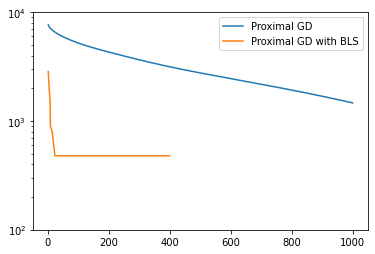

In [172]:
plt.plot(range(1,1001,1), result_C[1], label='Proximal GD')
plt.plot(range(1,401,1), result_D[1], label='Proximal GD with BLS')
plt.ylim([1e2,1e4])
plt.yscale('log')
plt.legend()

In [ ]:
### Predicting test set

In [178]:
optimal_beta = prox_gd(data, 5, iters=10000)[-1]

Iteration: 1/1000: 13408.054815941288
Iteration: 1000/1000: 1528.5139814277045
Iteration: 2000/1000: 18.30249015508423
Iteration: 3000/1000: 5.962038004455962
Iteration: 4000/1000: 5.676138458307435
Iteration: 5000/1000: 5.551061350162854
Iteration: 6000/1000: 5.480887884042602
Iteration: 7000/1000: 5.436794836229524
Iteration: 8000/1000: 5.4068104007387205
Iteration: 9000/1000: 5.385207835503479
Iteration: 10000/1000: 5.3689488514147


In [185]:
# Given by professor
y_pred = (np.exp(X_test.dot(optimal_beta))/(1+np.exp(X_test.dot(optimal_beta))) > 0.5).astype(int)
accuracy = np.mean(y_pred==y_test)

In [191]:
print('Classification Error: {:.2f}%'.format((1-accuracy)*100))

Classification Error: 22.22%
